# Rayleigth-Ritz Method

![image](\img\esquematico.png)

In [51]:
import numpy as np
from scipy import integrate
from scipy.misc import derivative
from scipy.linalg import eigh
import matplotlib.pyplot as plt
import json

pi = np.pi

In [52]:
# Beam parameters
L = 1.5                             # Length [m]
rho = 7700                          # Density [kg/m**3]
E = 2.1e11                          # Young's modulus [Pa]
A1 = pi * 0.03**2 / 4               # Area of section 1 [m**2]
A2 = pi * 0.06**2 / 4               # Area of section 2 [m**2]
A3 = pi * 0.03**2 / 4               # Area of section 3 [m**2]
I1 = (pi/4)*(0.03/2)**4             # Area moment of inetia of section 1 [m**4] 
I2 = (pi/4)*(0.06/2)**4             # Area moment of inetia of section 2 [m**4]
I3 = (pi/4)*(0.03/2)**4             # Area moment of inetia of section 3 [m**4]
m_eng = 20                          # Gear mass [kg]
J_eng = 0.25 * m_eng * 0.1**2       # Gear moment of inertiza about Z axis [kg*m**2]
k_mola = 2*10e3                     # Equivalent stiffness of the two springs [N/m]

# Base function feinition d_j(x)
def eta(j):
    if j==1:
        return 1.875/L
    if j>1:
        return (j-0.5)*pi/L

def D(etaj):
    etajL = etaj*L
    return ((np.cos(etajL) + np.cosh(etajL))/(np.sin(etajL) - np.sinh(etajL))).tolist()

def d(x, etaj):
    etajx = etaj*x
    D_ = D(etaj)
    # It was necessary to reformulate to avoid numerical errors when working with very large and very small numbers
    return np.sin(etajx) + D_*np.cos(etajx) - 0.5*((D_ - 1)*np.exp(-etajx) + (D_ + 1)*np.exp(etajx))


## Computing [K] and [M]

In [53]:
n = np.array([4, 8, 12, 16])  # Array with the number of base functions
N = np.max(n)
K = np.zeros((N, N))          # Stiffness matrix
M = np.zeros((N, N))          # Mass matrix

# Beam segments for numerical integration
L1 = np.linspace(0, L/3, 50000)
L2 = np.linspace(L/3, 2*L/3, 50000)
L3 = np.linspace(2*L/3, L, 50000)

didj = lambda x, i, j: d(x, eta(i))*d(x, eta(j))
diff2 = lambda x, i, j: derivative(d, x, n=2, dx=1e-6, args = (eta(i),))*derivative(d, x, n=2, dx=1e-6, args = (eta(j),))

for i in range(1, N+1):
    for j in range(i, N+1):

        M[i-1, j-1] = (rho*A1*integrate.simpson(didj(L1, i, j), L1)
                     + rho*A2*integrate.simpson(didj(L2, i, j), L2)
                     + rho*A3*integrate.simpson(didj(L3, i, j), L3)
                     + m_eng*d(L/3, eta(i))*d(L/3, eta(j))
                     + J_eng*derivative(d, L/3, dx=1e-6, args = (eta(i),))*derivative(d, L/3, dx=1e-6, args = (eta(j),)))

        K[i-1, j-1] = (E*I1*integrate.simpson(diff2(L1, i, j), L1)
                     + E*I2*integrate.simpson(diff2(L2, i, j), L2)
                     + E*I3*integrate.simpson(diff2(L3, i, j), L3)
                     + k_mola*d(2*L/3, eta(i))*d(2*L/3, eta(j)))

# Mirrorring the matrices, since they are symmetric
M = (M + M.T - np.diag(np.diagonal(M))).real
K = (K + K.T - np.diag(np.diagonal(K))).real

## Solving the generalized eigenvalue problem for [K] e [M]

In [54]:
results = dict()
x = np.linspace(0, L, int(L/0.001 + 1)) # Position where the rensponse will be calculated

# Computing the base functions at x
d_arr = np.zeros((N, x.size))
for j in range(1, N+1):
    d_arr[j-1,:] = d(x, eta(j))

for p in n:
    p = int(p)
    # Eigenvalue problem for real, symmetric dense matrices [K] and [M].
    # W is a 1D ndarray and Vc is a 2D ndarray with columns normalized to 1
    W, A = eigh(a=K[:p, :p], b=M[:p, :p])
    
    # Ordering eigenvalues and the eigenvectors matrix
    idx = W.argsort()
    W = W[idx].real
    A = A[:,idx].real

    # Normalizing eigenvectors matrix by the mass matrix, such that Vc.T @ M @ Vc = I
    m_r = np.diagonal(A.T @ M[:p, :p] @ A)
    m_r = np.reciprocal(np.sqrt(m_r))
    for a in range(A.shape[1]):
        A[:,a] *= m_r[a] # multiply every column by the scale factor
    
    dj = d_arr[:p, :]    # slices the array up to the desired number of base functions

    # Make the mode shapes have the same orientation analising the covariance with the first coputed case
    # to be able to compare between different number of base functions
    phi = dj.T @ A
    try:
        for k in range(p): # k-th mode
            cov = np.cov(results[n[0]]['V'][:,k], phi[:,k])[0][1]
            cov = cov/np.abs(cov) # -1 or 1
            phi[:,k] *= cov
    except:
        pass
        
    # Store in a dict
    results[p] = dict()
    results[p]['V'] = phi
    results[p]['fn'] = np.real(W**0.5/(2*np.pi))
    results[p]['d'] = dj

# Base functions

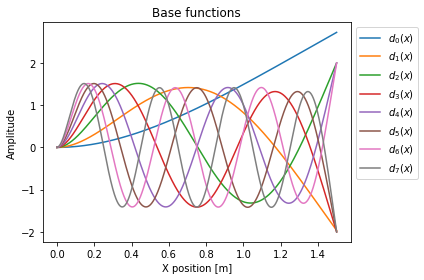

In [55]:
N = n[1]
for i in range(N):
    plt.plot(x, results[N]['d'][i], label=f'$d_{i}(x)$')

plt.title('Base functions')
plt.xlabel('X position [m]')
plt.ylabel('Amplitude')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
# plt.grid(True)
plt.tight_layout()
plt.savefig("img/funcoes_de_base.pdf")
plt.show()

# Mode Shapes

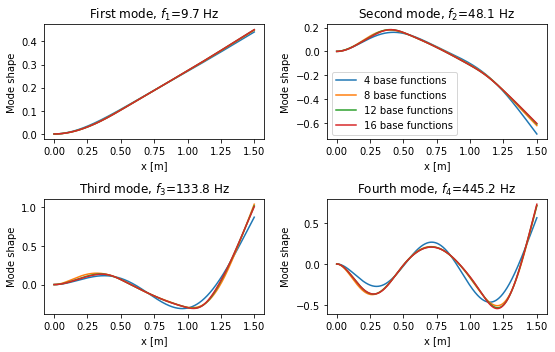

In [56]:
fig, axs = plt.subplots(2,2)

for n_b in n:
    axs[0,0].set_title(f"First mode, $f_1$={results[n_b]['fn'][0]:.1f} Hz")
    axs[0,0].plot(x, results[n_b]['V'][:,0], label=f"{n_b} base functions")
    axs[0,0].set_xlabel('x [m]')
    axs[0,0].set_ylabel('Mode shape')
    
    axs[0,1].set_title(f"Second mode, $f_2$={results[n_b]['fn'][1]:.1f} Hz")
    axs[0,1].plot(x, results[n_b]['V'][:,1])
    axs[0,1].set_xlabel('x [m]')
    axs[0,1].set_ylabel('Mode shape')

    axs[1,0].set_title(f"Third mode, $f_3$={results[n_b]['fn'][2]:.1f} Hz")
    axs[1,0].plot(x, results[n_b]['V'][:,2])
    axs[1,0].set_xlabel('x [m]')
    axs[1,0].set_ylabel('Mode shape')

    axs[1,1].set_title(f"Fourth mode, $f_4$={results[n_b]['fn'][3]:.1f} Hz")
    axs[1,1].plot(x, results[n_b]['V'][:,3])
    axs[1,1].set_xlabel('x [m]')
    axs[1,1].set_ylabel('Mode shape')

fig.legend(loc='lower left', bbox_to_anchor=(0.6, 0.6))
fig.set_size_inches(8,5)
fig.tight_layout()
plt.savefig("img/comparacao_das_formas_modais.pdf")
plt.show()

In [57]:
A.shape

(16, 16)

# Comparing Natural Frequencies

In [58]:
import pandas as pd
pd.options.display.float_format = "{:.2f}".format
df = pd.DataFrame(data=[results[n_b]['fn'] for n_b in n], index=[f"n={i}" for i in n], columns=[f"f_{j}" for j in range(1, n.max()+1)])
df

,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,f_11,f_12,f_13,f_14,f_15,f_16
n=4,9.85,61.39,218.68,506.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
n=8,9.73,51.02,147.71,449.84,681.93,839.65,1515.87,2333.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
n=12,9.71,48.97,136.75,446.54,633.47,803.22,1281.28,1829.31,2004.04,2859.91,4715.18,5673.22,NaN,NaN,NaN,NaN
n=16,9.70,48.07,133.79,445.15,620.92,785.39,1264.21,1754.97,1912.75,2813.96,3561.87,3837.44,5311.90,6391.26,9081.09,10033.78


In [59]:
print(df.iloc[:,0:4].to_latex(na_rep="-"))

\begin{tabular}{lrrrr}
\toprule
{} &  f\_1 &   f\_2 &    f\_3 &    f\_4 \\
\midrule
n=4  & 9.85 & 61.39 & 218.68 & 506.06 \\
n=8  & 9.73 & 51.02 & 147.71 & 449.84 \\
n=12 & 9.71 & 48.97 & 136.75 & 446.54 \\
n=16 & 9.70 & 48.07 & 133.79 & 445.15 \\
\bottomrule
\end{tabular}



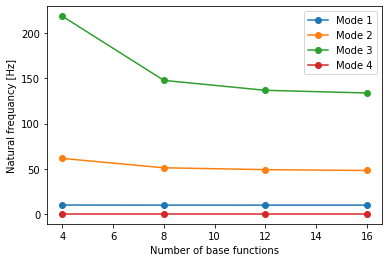

In [60]:
fn_N=np.zeros((4, len(n)))
for j in range(0,3):
    for k in range(len(n)):
        fn_N[j, k] = results[n[k]]['fn'][j]
        
for k in range(fn_N[1,:].size):
    plt.plot(n, fn_N[k,:], marker='o')
plt.xlabel('Number of base functions')
plt.ylabel('Natural frequancy [Hz]')
plt.legend(['Mode 1', 'Mode 2','Mode 3', 'Mode 4'])
# plt.yscale('log')
# plt.grid(True)
fig.tight_layout()
plt.savefig("img/comparacao_das_freq_naturais.pdf")
plt.show()

# Export results to .json file

In [62]:
# Convert numpy to list
results2 = dict()
for p in n:
    p = int(p)
    results2[p] = dict()
    results2[p]['V'] = results[p]['V'].tolist()
    results2[p]['fn'] = results[p]['fn'].tolist()
    results2[p]['d'] = results[p]['d'].tolist()

with open('RRM_result.json', 'w') as fp:
    json.dump(results2, fp)